# 0) Title & Setup

- Notebook title: DSA4213 Assignment 2 – RNN, LSTM on the book *An Inquiry into the Nature and Causes of the Wealth of Nations* of *Adam Smith*
- Objective: Train 3 models, compare with perplexity, loss curves, generation, and ablations.

# 1) Environment Check

* This section makes sure my Colab runtime is ready and reproducible.

**What I do in this section**

1.  Detect the GPU (name + memory).
2.  Print Python and PyTorch versions.
3.  Set global seeds for reproducibility.
4. Configure deterministic behavior (where practical).
5.  Define a tiny helper to format time and a central config block you can tweak later.

*If I switch runtimes (e.g., reconnect), I will run this section again before training*

In [ ]:
# 1.1 GPU INFO
!nvidia-smi -L || echo "No NVIDIA GPU detected."
!nvidia-smi || true

GPU 0: Tesla T4 (UUID: GPU-5409364f-7214-1da1-e4cb-d120a187987f)
Fri Sep 12 11:16:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |       

In [ ]:
# 1.2 PYTHON & PYTORCH VERSIONS
import sys, torch
print("Python :", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA   :", torch.version.cuda)
print("GPU    :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

Python : 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA   : 12.6
GPU    : Tesla T4


In [ ]:
# 1.3 SEEDS & DETERMINISM
import os, random, numpy as np, torch

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Deterministic flags (can slightly slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Mixed precision toggle (useful later; keep False unless needed)
USE_AMP = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("AMP enabled:", USE_AMP)

Device: cuda
AMP enabled: False


In [ ]:
# 1.4 GLOBAL CONFIG & TIMER HELPERS
from dataclasses import dataclass
import time

@dataclass
class RunConfig:
    seed: int = SEED
    use_amp: bool = False
    device: str = str(device)
    # data sizing defaults will be filled later (Section 2)
    train_token_cap: int | None = None  # e.g., 5_000_000
    block_size: int = 128               # context length (ablate to 256 later)
    batch_size: int = 64

CFG = RunConfig(use_amp=USE_AMP)
print(CFG)

class Timer:
    def __enter__(self):
        self.t0 = time.time()
        return self
    def __exit__(self, *exc):
        self.dt = time.time() - self.t0

def hhmmss(seconds: float) -> str:
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

RunConfig(seed=1337, use_amp=False, device='cuda', train_token_cap=None, block_size=128, batch_size=64)


# 2) Data Import and Preparation

## 2.1) Import data


In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/dsa4213-assignment2/data"
os.makedirs(DATA_DIR, exist_ok=True)

TRAIN_FILE = os.path.join(DATA_DIR, "pg3300.txt")
assert os.path.exists(TRAIN_FILE), f"Missing file: {TRAIN_FILE}"

print("Data directory:", DATA_DIR)
print("Train file size (MB):", round(os.path.getsize(TRAIN_FILE) / 1e6, 2))

# Load the raw text
with open(TRAIN_FILE, "r", encoding="utf-8", errors="ignore") as f:
    raw_text = f.read()

print("Loaded characters:", len(raw_text))
print("Preview:\n", raw_text[:1000])

Mounted at /content/drive
Data directory: /content/drive/MyDrive/dsa4213-assignment2/data
Train file size (MB): 2.47
Loaded characters: 2432686
Preview:
 ﻿The Project Gutenberg eBook of An Inquiry into the Nature and Causes of the Wealth of Nations
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: An Inquiry into the Nature and Causes of the Wealth of Nations

Author: Adam Smith

Release date: June 1, 2002 [eBook #3300]
                Most recently updated: July 3, 2025

Language: English

Credits: Credits: Colin Muir and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK AN INQUIR

## 2.2) Data preparation

In [ ]:
# === 2.2) Data preparation (cleaning, tokenization) ===
import re
from typing import List

SPECIAL_TOKENS = ["<pad>", "<unk>", "<bos>", "<eos>"]

def default_clean(text: str) -> str:
    # normalize line endings
    text = re.sub(r'\r\n?', '\n', text)
    # strip Gutenberg header/footer if present
    up = text.upper()
    sm = "*** START OF THE PROJECT GUTENBERG EBOOK"
    em = "*** END OF THE PROJECT GUTENBERG EBOOK"
    sidx, eidx = up.find(sm), up.find(em)
    if sidx != -1 and eidx != -1 and eidx > sidx:
        text = text[sidx:].splitlines()[1:]  # drop marker line
        text = "\n".join(text)
        text = text[:text.upper().find(em)]
    # normalize whitespace (keep paragraph breaks)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    return text.strip()

def word_tokenize(text: str) -> List[str]:
    # lowercase and split punctuation into separate tokens
    text = text.lower()
    text = re.sub(r'([.,!?;:()"\-“”‘’—])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().split()

def char_tokenize(text: str) -> List[str]:
    return list(text)

# choose tokenization mode: "word" or "char"
TOKEN_MODE = "word"

clean_text = default_clean(raw_text)
tokens = word_tokenize(clean_text) if TOKEN_MODE == "word" else char_tokenize(clean_text)
print(f"Total tokens (pre-cap): {len(tokens):,}")
print(tokens[:50])

Total tokens (pre-cap): 437,165
['an', 'inquiry', 'into', 'the', 'nature', 'and', 'causes', 'of', 'the', 'wealth', 'of', 'nations', 'by', 'adam', 'smith', 'contents', 'introduction', 'and', 'plan', 'of', 'the', 'work', '.', 'book', 'i', '.', 'of', 'the', 'causes', 'of', 'improvement', 'in', 'the', 'productive', 'powers', 'of', 'labour', ',', 'and', 'of', 'the', 'order', 'according', 'to', 'which', 'its', 'produce', 'is', 'naturally', 'distributed']


## 2.3) Split into 80/10/10

In [ ]:
# === 2.3) Split data (80/10/10) ===
from collections import Counter
from typing import List

VOCAB_SIZE = 20_000

# build vocab by frequency
counter = Counter(tokens)
most_common = [tok for tok, _ in counter.most_common(max(0, VOCAB_SIZE - len(SPECIAL_TOKENS)))]
itos = SPECIAL_TOKENS + most_common
stoi = {t:i for i,t in enumerate(itos)}

PAD_ID, UNK_ID, BOS_ID, EOS_ID = stoi["<pad>"], stoi["<unk>"], stoi["<bos>"], stoi["<eos>"]

def encode(seq: List[str]) -> List[int]:
    return [stoi.get(t, UNK_ID) for t in seq]

def decode(ids: List[int]) -> List[str]:
    return [itos[i] for i in ids]

# build continuous id stream
if TOKEN_MODE == "word":
    # add <bos>/<eos> per paragraph to give the LM useful boundary signals
    paras = [p.strip() for p in clean_text.split("\n\n") if p.strip()]
    stream: List[str] = []
    for p in paras:
        ptoks = word_tokenize(p)
        stream += ["<bos>"] + ptoks + ["<eos>"]
else:
    stream = tokens  # char mode uses a flat stream

ids = encode(stream)
N = len(ids)

# 80/10/10 sequential split (preserves natural text order)
n_train = int(0.8 * N)
n_val   = int(0.9 * N)

train_ids = ids[:n_train]
val_ids   = ids[n_train:n_val]
test_ids  = ids[n_val:]

print(f"Vocab size: {len(itos):,}")
print(f"Tokens: total={N:,} | train={len(train_ids):,} | val={len(val_ids):,} | test={len(test_ids):,}")

# quick sanity: show first few decoded tokens from each split (word-mode)
if TOKEN_MODE == "word":
    print("Sample train tokens:", decode(train_ids[:30]))

Vocab size: 10,359
Tokens: total=441,551 | train=353,240 | val=44,155 | test=44,156
Sample train tokens: ['<bos>', 'an', 'inquiry', 'into', 'the', 'nature', 'and', 'causes', 'of', 'the', 'wealth', 'of', 'nations', '<eos>', '<bos>', 'by', 'adam', 'smith', '<eos>', '<bos>', 'contents', '<eos>', '<bos>', 'introduction', 'and', 'plan', 'of', 'the', 'work', '.']


# 3) Models

## 3.1) Initialize model classes (RNN, LSTM)

In [ ]:
# === 3.1) Model classes ===
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_layers=1, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.rnn = nn.RNN(d_model, d_model, num_layers=num_layers, batch_first=True,
                          nonlinearity='tanh', dropout=dropout if num_layers > 1 else 0.0)
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, x, hidden=None):
        x = self.emb(x)
        out, hidden = self.rnn(x, hidden)
        out = self.ln(out)
        logits = self.head(out)
        return logits, hidden

class LSTMLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_layers=1, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.lstm = nn.LSTM(d_model, d_model, num_layers=num_layers, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, x, hidden=None):
        x = self.emb(x)
        out, hidden = self.lstm(x, hidden)
        out = self.ln(out)
        logits = self.head(out)
        return logits, hidden

## 3.2) Custom dataset

In [ ]:
# === 3.2) Custom dataset ===
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, id_list, seq_len: int):
        self.ids = id_list
        self.seq_len = seq_len

    def __len__(self):
        return max(0, len(self.ids) - self.seq_len)

    def __getitem__(self, idx):
        x = torch.tensor(self.ids[idx: idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.ids[idx + 1: idx + 1 + self.seq_len], dtype=torch.long)
        return x, y

## 3.3) Hyperparameters (training-level)

In [ ]:
# === 3.3) Hyperparameters ===

SEQ_LEN     = 128 if TOKEN_MODE == "word" else 256
BATCH_SIZE  = 64

# Model hyperparameters
EMBED_SIZE  = 128
HIDDEN_SIZE = 256
NUM_LAYERS  = 2
DROPOUT     = 0.2
N_HEADS     = 4

# Training setup
LEARNING_RATE = 1e-3
NUM_EPOCHS    = 10
GRAD_CLIP     = 1.0
SEED          = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)

print(f"SEQ_LEN={SEQ_LEN}, EMBED_SIZE={EMBED_SIZE}, HIDDEN_SIZE={HIDDEN_SIZE}, "
      f"NUM_LAYERS={NUM_LAYERS}, DROPOUT={DROPOUT}, LR={LEARNING_RATE}, "
      f"EPOCHS={NUM_EPOCHS}, device={device}")

SEQ_LEN=128, EMBED_SIZE=128, HIDDEN_SIZE=256, NUM_LAYERS=2, DROPOUT=0.2, LR=0.001, EPOCHS=10, device=cuda


## 3.4) Create Dataset and DataLoader

In [ ]:
# === 3.4) Create Dataset and DataLoader ===
train_loader = DataLoader(SeqDataset(train_ids, SEQ_LEN), batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(SeqDataset(val_ids,   SEQ_LEN), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader  = DataLoader(SeqDataset(test_ids,  SEQ_LEN), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)

Batch shapes: torch.Size([64, 128]) torch.Size([64, 128])


# 4) Training Models

## 4.1) Helpers (save/load to Drive, RNN+LSTM only)

In [17]:
# === 4.1) Helpers: build, evaluate, train-one, save/load (Drive) ===
import math, time, torch, json, os, re
import torch.nn as nn
from datetime import datetime

# -------- Model factory (RNN + LSTM only) --------
def build_model(name, vocab_size):
    if name == "rnn":
        return RNNLM(vocab_size, d_model=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
    elif name == "lstm":
        return LSTMLM(vocab_size, d_model=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
    else:
        raise ValueError(f"Unknown model: {name} (expected 'rnn' or 'lstm')")

# -------- Perplexity evaluation --------
@torch.no_grad()
def evaluate_ppl(model, loader):
    model.eval()
    total_loss, total_tokens = 0.0, 0
    criterion = nn.CrossEntropyLoss(reduction="sum")
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, _ = model(x)
        total_loss += criterion(logits.view(-1, logits.size(-1)), y.view(-1)).item()
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

# -------- Where to save: to Google Drive --------
DRIVE_ROOT = "/content/drive/MyDrive/dsa4213-assignment2"
RUN_ID = datetime.now().strftime("%Y%m%d-%H%M%S")
BASE_DIR = os.path.join(DRIVE_ROOT, "runs", RUN_ID)
os.makedirs(BASE_DIR, exist_ok=True)

def get_model_dir(model_name):
    d = os.path.join(BASE_DIR, model_name)
    os.makedirs(d, exist_ok=True)
    return d

def current_config_dict():
    return {
        "token_mode": TOKEN_MODE,
        "seq_len": SEQ_LEN,
        "batch_size": BATCH_SIZE,
        "embedding_size": EMBED_SIZE,
        "hidden_size": HIDDEN_SIZE,
        "num_layers": NUM_LAYERS,
        "dropout": DROPOUT,
        "learning_rate": LEARNING_RATE,
        "num_epochs": NUM_EPOCHS,
        "grad_clip": GRAD_CLIP,
        "seed": SEED,
        "vocab_size": len(itos),
        "device": device,
    }

def save_vocab_and_config(model_name):
    mdir = get_model_dir(model_name)
    with open(os.path.join(mdir, "vocab.json"), "w") as f:
        json.dump({"itos": itos, "special": SPECIAL_TOKENS}, f)
    with open(os.path.join(mdir, "config.json"), "w") as f:
        json.dump(current_config_dict(), f, indent=2)

def save_best_checkpoint(model_name, model, best_val_ppl):
    mdir = get_model_dir(model_name)
    payload = {
        "model_name": model_name,
        "state_dict": model.state_dict(),
        "config": current_config_dict(),
        "best_val_ppl": float(best_val_ppl),
        "timestamp": time.time(),
    }
    torch.save(payload, os.path.join(mdir, "best.pt"))

# -------- Train loop with early stopping + metrics.json (written to Drive) --------
def train_one_model(model_name, vocab_size, train_loader, val_loader, patience=2, min_delta=0.0):
    model = build_model(model_name, vocab_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    best_val = float("inf")
    bad_epochs = 0
    step = 0

    history = {"train_loss": [], "val_ppl": [], "epoch_sec": []}

    # Also save "working best" (local temp) to reload before packing into Drive
    temp_best_path = f"{model_name}_best.pt"

    for ep in range(1, NUM_EPOCHS + 1):
        t0 = time.time()
        model.train()
        running = 0.0

        for x, y in train_loader:
            step += 1
            x, y = x.to(device), y.to(device)

            logits, _ = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            running += loss.item()
            if step % 200 == 0:
                avg_loss = running / 200
                print(f"{model_name} | ep {ep:02d} step {step:05d} | train_loss {avg_loss:.4f}")
                history["train_loss"].append(avg_loss)
                running = 0.0

        val_ppl = evaluate_ppl(model, val_loader)
        sec = time.time() - t0
        history["val_ppl"].append(val_ppl)
        history["epoch_sec"].append(sec)
        print(f"{model_name} | epoch {ep:02d} | val PPL {val_ppl:.2f} | time {sec:.1f}s")

        if val_ppl + min_delta < best_val:
            best_val = val_ppl
            bad_epochs = 0
            torch.save(model.state_dict(), temp_best_path)  # local temp
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"{model_name} | early stopping at epoch {ep:02d} (best val PPL {best_val:.2f})")
                break

    # Write metrics.json to Drive
    mdir = get_model_dir(model_name)
    with open(os.path.join(mdir, "metrics.json"), "w") as f:
        json.dump({
            "train_loss": history["train_loss"],
            "val_ppl": history["val_ppl"],
            "epoch_sec": history["epoch_sec"],
            "best_val_ppl": float(best_val)
        }, f, indent=2)

    # Pack final best.pt (weights + config) to Drive
    # Reload temp-best weights into a fresh model to ensure clean state dict
    mdl = build_model(model_name, vocab_size)
    mdl.load_state_dict(torch.load(temp_best_path, map_location=device))
    save_best_checkpoint(model_name, mdl, best_val)

    # Optional: remove local temp file
    if os.path.exists(temp_best_path):
        os.remove(temp_best_path)

    return best_val, history

# -------- Load from Drive (latest RUN_ID by default) --------
import os, json, torch

def load_trained_model(model_name, run_id="20250912-080505"):
    # Define the fixed run root (no more base_dir)
    run_root = f"/content/drive/MyDrive/dsa4213-assignment2/runs/{run_id}"

    # Paths
    mdir = os.path.join(run_root, model_name)
    ckpt_path = os.path.join(mdir, "best.pt")
    vocab_path = os.path.join(mdir, "vocab.json")

    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    cfg = ckpt["config"]

    # Rebuild model
    model = build_model(model_name, cfg["vocab_size"])
    model.load_state_dict(ckpt["state_dict"])

    # Load vocab
    with open(vocab_path, "r") as f:
        vobj = json.load(f)
    loaded_itos = vobj["itos"]
    loaded_special = vobj.get("special", SPECIAL_TOKENS)

    return model, ckpt, loaded_itos, loaded_special, run_id


# Example usage
model, ckpt, itos, special, run_id = load_trained_model("rnn")
print("Loaded from run:", run_id)

Loaded from run: 20250912-080505


## 4.2) Train Models

In [ ]:
# === 4.2) Train and save baselines (RNN + LSTM) to Drive ===
models_to_train = ["rnn", "lstm"]
results = {}
histories = {}

for m in models_to_train:
    print(f"\n=== Training {m.upper()} ===")
    save_vocab_and_config(m)

    best_val_ppl, hist = train_one_model(
        m, len(itos), train_loader, val_loader,
        patience=2, min_delta=0.0
    )
    results[m] = best_val_ppl
    histories[m] = hist

print("\nFinished baseline training.")
print("Validation PPL summary:", results)
print("Saved under:", BASE_DIR)


=== Training RNN ===
rnn | ep 01 step 00200 | train_loss 4.9091
rnn | ep 01 step 00400 | train_loss 3.9266
rnn | ep 01 step 00600 | train_loss 3.5099
rnn | ep 01 step 00800 | train_loss 3.1973
rnn | ep 01 step 01000 | train_loss 2.9612
rnn | ep 01 step 01200 | train_loss 2.7805
rnn | ep 01 step 01400 | train_loss 2.6332
rnn | ep 01 step 01600 | train_loss 2.5093
rnn | ep 01 step 01800 | train_loss 2.4012
rnn | ep 01 step 02000 | train_loss 2.3063
rnn | ep 01 step 02200 | train_loss 2.2259
rnn | ep 01 step 02400 | train_loss 2.1605
rnn | ep 01 step 02600 | train_loss 2.0950
rnn | ep 01 step 02800 | train_loss 2.0350
rnn | ep 01 step 03000 | train_loss 1.9831
rnn | ep 01 step 03200 | train_loss 1.9344
rnn | ep 01 step 03400 | train_loss 1.8799
rnn | ep 01 step 03600 | train_loss 1.8463
rnn | ep 01 step 03800 | train_loss 1.8043
rnn | ep 01 step 04000 | train_loss 1.7711
rnn | ep 01 step 04200 | train_loss 1.7366
rnn | ep 01 step 04400 | train_loss 1.6957
rnn | ep 01 step 04600 | train_l

# 5) Evaluation

**What I'll do in this section**
* report validation & test perplexity
* generate samples at T = 0.7, 1.0, 1.3
* plot training & validation loss curves
* record training time

## 5.1) Load best checkpoints & report Val/Test Perplexity

In [ ]:
# === 5.1) Load best checkpoints & compute Val/Test PPL ===

def ppl_of(model_name, run_id="20250912-080505"):
    model, _, _, _, used = load_trained_model(model_name, run_id=run_id)
    val_ppl = evaluate_ppl(model, val_loader)
    test_ppl = evaluate_ppl(model, test_loader)
    return used, val_ppl, test_ppl

for name in ["rnn", "lstm"]:
    run_used, v_ppl, t_ppl = ppl_of(name)
    print(f"{name.upper()} | run {run_used} | val PPL: {v_ppl:.2f} | test PPL: {t_ppl:.2f}")

RNN | run 20250912-080505 | val PPL: 1515.10 | test PPL: 1065.74
LSTM | run 20250912-080505 | val PPL: 9376.26 | test PPL: 6937.49


## 5.2) Text generation at T = 0.7, 1.0, 1.3 (per model)

In [18]:
# === 5.2) Text generation for each model at multiple temperatures ===
import torch

def decode_text(ids, itos, token_mode):
    toks = [itos[i] for i in ids]
    if token_mode == "word":
        toks = [t for t in toks if t not in ("<bos>", "<eos>", "<pad>")]
        return " ".join(toks)
    else:
        return "".join(toks)

@torch.no_grad()
def sample(model, start_ids, max_new_tokens=80, temperature=1.0, top_k=None):
    model.eval()
    x = start_ids.clone().to(device).unsqueeze(0)
    out = x
    for _ in range(max_new_tokens):
        logits, _ = model(out[:, -x.size(1):])
        logits = logits[:, -1, :] / max(1e-8, temperature)
        if top_k is not None:
            v, _ = torch.topk(logits, k=top_k, dim=-1)
            logits[logits < v[:, [-1]]] = -float("inf")
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        out = torch.cat([out, next_id], dim=1)
    return out.squeeze(0)

def generate_for_model(model_name, prompt="the economy", run_id="20250912-080505", max_new=80, temps=(0.7, 1.0, 1.3)):
    model, _, itos_loaded, special_loaded, used = load_trained_model(model_name, run_id=run_id)
    stoi_loaded = {t:i for i,t in enumerate(itos_loaded)}
    bos_id = stoi_loaded.get("<bos>", None)

    if TOKEN_MODE == "word":
        start_tokens = []
        if bos_id is not None: start_tokens.append("<bos>")
        start_tokens += prompt.lower().split()
        start_ids = torch.tensor([stoi_loaded.get(t, stoi_loaded.get("<unk>", 0)) for t in start_tokens])
    else:
        start_ids = torch.tensor([stoi_loaded.get(ch, stoi_loaded.get("<unk>", 0)) for ch in list(prompt)])

    print(f"\n=== {model_name.upper()} | run {used} | prompt: \"{prompt}\" ===")
    for T in temps:
        out_ids = sample(model, start_ids, max_new_tokens=max_new, temperature=T, top_k=50)
        text = decode_text(out_ids.tolist(), itos_loaded, TOKEN_MODE)
        print(f"\n[T = {T}]")
        print(text)

In [19]:
# Run generation for both models
for name in ["rnn", "lstm"]:
    generate_for_model(name, prompt="What are the fundamental principles that lead to a nation's wealth ?", max_new=100)


=== RNN | run 20250912-080505 | prompt: "What are the fundamental principles that lead to a nation's wealth ?" ===

[T = 0.7]
what are the fundamental principles that lead to a <unk> wealth ? the money price of corn , and the rent of land is always a greater proportion , than with that of butcher ’ s meat . the whole value of the annual produce , the quantity of gold and employed in the british manufactures of those particular , far from tending to make anybody gradually loss how much . though the loss of this waste and unimproved east india , the greater part of it was found to be so . before that period , it was found , that the one species of food , clothing ,

[T = 1.0]
what are the fundamental principles that lead to a <unk> wealth ? the number of a particular commodity , over and above the number of other people are , the more stock than any one of them must have been the merchants of several nations ; the trade would lie much cheaper , and go to one half . the rent above the ne

In [20]:
for name in ["rnn", "lstm"]:
    generate_for_model(name, prompt="The abundance or scantiness of this supply, too, seems to depend more upon  the former of those two circumstances than upon the latter. Among the savage nations of hunters and fishers, every individual who is able to       work is more or less employed in useful labour, and endeavours to provide, as well as he can, the necessaries and conveniencies of life, for himself, and such of his family or tribe as are either too old, or too young, or too infirm, to go a-hunting and fishing. Such nations, however, are so       miserably poor, that, from mere want, they are frequently reduced, or at       least think themselves reduced, to the necessity sometimes of directly destroying, and sometimes of abandoning their infants, their old people, and those afflicted with lingering diseases, to perish with hunger, or to be devoured by wild beasts", max_new=100)


=== RNN | run 20250912-080505 | prompt: "The abundance or scantiness of this supply, too, seems to depend more upon  the former of those two circumstances than upon the latter. Among the savage nations of hunters and fishers, every individual who is able to       work is more or less employed in useful labour, and endeavours to provide, as well as he can, the necessaries and conveniencies of life, for himself, and such of his family or tribe as are either too old, or too young, or too infirm, to go a-hunting and fishing. Such nations, however, are so       miserably poor, that, from mere want, they are frequently reduced, or at       least think themselves reduced, to the necessity sometimes of directly destroying, and sometimes of abandoning their infants, their old people, and those afflicted with lingering diseases, to perish with hunger, or to be devoured by wild beasts" ===

[T = 0.7]
the abundance or scantiness of this <unk> <unk> seems to depend more upon the former of those tw

## 5.3) Plot training loss & validation curves (per model)

Plot training loss & validation curves (per model)

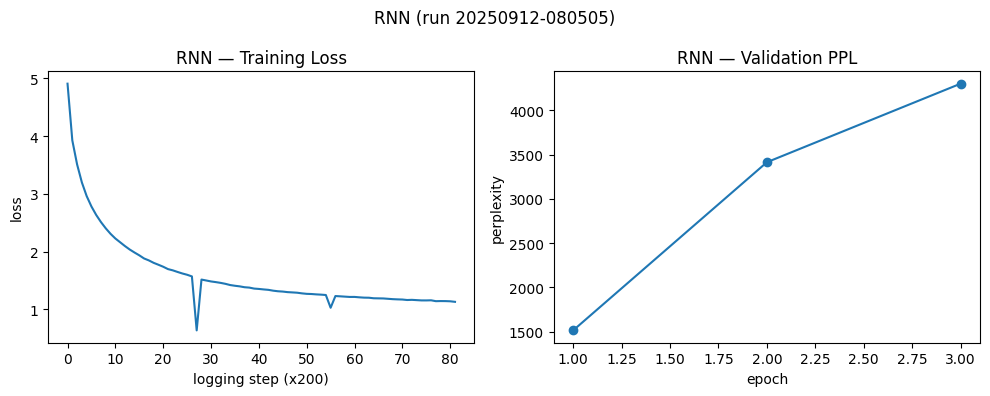

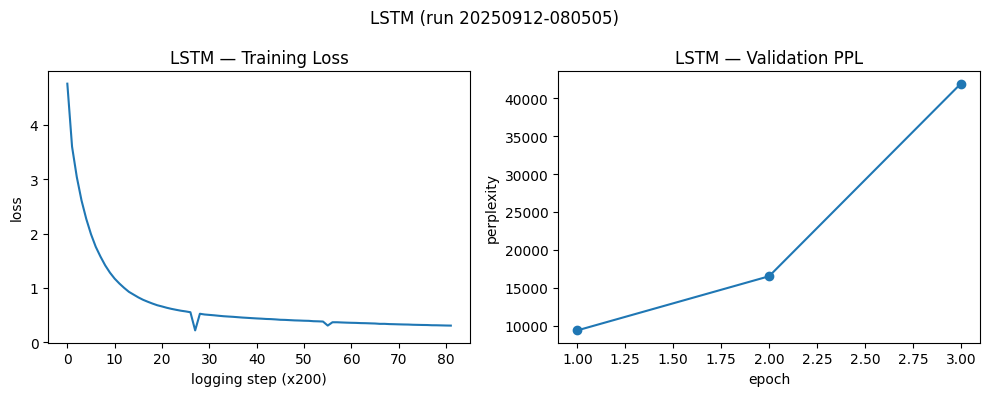

In [ ]:
# === 5.3) Plot training loss and validation curves (from metrics.json) ===
import matplotlib.pyplot as plt

def load_metrics(model_name, run_id="20250912-080505"):
    _, _, _, _, used = load_trained_model(model_name, run_id=run_id)
    mdir = os.path.join(DRIVE_ROOT, "runs", used, model_name)
    metrics_path = os.path.join(mdir, "metrics.json")
    if not os.path.exists(metrics_path):
        raise FileNotFoundError(f"No metrics.json found for {model_name} in run {used}")
    with open(metrics_path, "r") as f:
        return json.load(f), used

for m in ["rnn", "lstm"]:
    metrics, used = load_metrics(m)
    tl = metrics.get("train_loss", [])
    vp = metrics.get("val_ppl", [])
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(tl)
    ax[0].set_title(f"{m.upper()} — Training Loss")
    ax[0].set_xlabel("logging step (x200)")
    ax[0].set_ylabel("loss")
    ax[1].plot(range(1, len(vp)+1), vp, marker="o")
    ax[1].set_title(f"{m.upper()} — Validation PPL")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("perplexity")
    plt.suptitle(f"{m.upper()} (run {used})")
    plt.tight_layout()
    plt.show()

## 5.4) Record & summarize training time

In [ ]:
# === 5.4) Training time summary (from metrics.json) ===
import numpy as np

for m in ["rnn", "lstm"]:
    metrics, used = load_metrics(m)
    secs = metrics.get("epoch_sec", [])
    if secs:
        total = float(np.sum(secs))
        print(f"{m.upper()} | run={used} | epochs={len(secs)} | total time: {total/60:.2f} min | per-epoch avg: {np.mean(secs):.1f}s")
    else:
        print(f"{m.upper()} | run={used} | no epoch timing recorded.")

RNN | run=20250912-080505 | epochs=3 | total time: 16.11 min | per-epoch avg: 322.1s
LSTM | run=20250912-080505 | epochs=3 | total time: 21.19 min | per-epoch avg: 423.8s


# 6) Ablation Studies

**What I'll do in this section**

Runs 2 ablations:
1. Dropout: 0.0 vs 0.2
2. Context length: 128 vs 256


## 6.0) Setup

In [ ]:
# === 6.0) Ablation setup & utilities ===
import os, re, time, math, json, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from typing import List

# Models to test in ablations
ABLATION_MODELS = ["rnn", "lstm"]

# Ablation run settings
ABLATION_EPOCHS = 2       # short runs for comparison (normal for ablations)
ABLATION_PATIENCE = 1
ABLATION_MIN_DELTA = 0.0
ABLATION_BATCH_SIZE = 64
ABLATION_MAX_TOKENS = None   # None = full dataset (prof requirement)

SPECIAL_TOKENS = ["<pad>", "<unk>", "<bos>", "<eos>"]

# ---------- Dataset wrapper ----------
class SeqDataset(Dataset):
    def __init__(self, id_list, seq_len: int):
        self.ids = id_list
        self.seq_len = seq_len
    def __len__(self):
        return max(0, len(self.ids) - self.seq_len)
    def __getitem__(self, idx):
        x = torch.tensor(self.ids[idx: idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.ids[idx + 1: idx + 1 + self.seq_len], dtype=torch.long)
        return x, y

def make_loader(ids, seq_len, batch_size, shuffle):
    return DataLoader(SeqDataset(ids, seq_len), batch_size=batch_size, shuffle=shuffle, drop_last=True)

# ---------- Cleaning & Tokenizers ----------
def default_clean(text: str) -> str:
    text = re.sub(r'\r\n?', '\n', text)
    up = text.upper()
    sm = "*** START OF THE PROJECT GUTENBERG EBOOK"
    em = "*** END OF THE PROJECT GUTENBERG EBOOK"
    sidx, eidx = up.find(sm), up.find(em)
    if sidx != -1 and eidx != -1 and eidx > sidx:
        text = text[sidx:].splitlines()[1:]
        text = "\n".join(text)
        text = text[:text.upper().find(em)]
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    return text.strip()

def word_tokenize(s: str) -> List[str]:
    s = s.lower()
    s = re.sub(r'([.,!?;:()"\-“”‘’—])', r' \1 ', s)
    s = re.sub(r'\s+', ' ', s)
    return s.strip().split()

def char_tokenize(s: str) -> List[str]:
    return list(s)

# ---------- Data Preparation ----------
def prepare_ablation_data(raw_text: str, token_mode: str, seq_len: int):
    """
    token_mode: "word" | "char"
    Returns: (itos, train_ids, val_ids, test_ids, train_loader, val_loader, test_loader, extra)
    """
    clean_txt = default_clean(raw_text)

    if token_mode == "word":
        toks = word_tokenize(clean_txt)
    elif token_mode == "char":
        toks = char_tokenize(clean_txt)
    else:
        raise ValueError("Unknown token_mode")

    if ABLATION_MAX_TOKENS and len(toks) > ABLATION_MAX_TOKENS:
        toks = toks[:ABLATION_MAX_TOKENS]

    counter = Counter(toks)
    vocab_cap = 20000 if token_mode == "word" else min(500, len(counter) + len(SPECIAL_TOKENS))
    most_common = [t for t, _ in counter.most_common(max(0, vocab_cap - len(SPECIAL_TOKENS)))]
    itos = SPECIAL_TOKENS + most_common
    stoi = {t:i for i,t in enumerate(itos)}
    PAD_ID, UNK_ID, BOS_ID, EOS_ID = stoi["<pad>"], stoi["<unk>"], stoi["<bos>"], stoi["<eos>"]

    def encode(tokens):
        return [stoi.get(t, UNK_ID) for t in tokens]

    if token_mode == "word":
        # Add <bos>/<eos> per paragraph
        paras = [p.strip() for p in clean_txt.split("\n\n") if p.strip()]
        stream = []
        for p in paras:
            ptoks = word_tokenize(p)
            stream += ["<bos>"] + ptoks + ["<eos>"]
    else:
        stream = toks

    ids = encode(stream)
    N = len(ids)
    n_train, n_val = int(0.8 * N), int(0.9 * N)

    train_ids, val_ids, test_ids = ids[:n_train], ids[n_train:n_val], ids[n_val:]
    tr_loader = make_loader(train_ids, seq_len, ABLATION_BATCH_SIZE, True)
    va_loader = make_loader(val_ids, seq_len, ABLATION_BATCH_SIZE, False)
    te_loader = make_loader(test_ids, seq_len, ABLATION_BATCH_SIZE, False)

    extra = {"stoi": stoi, "PAD_ID": PAD_ID, "UNK_ID": UNK_ID, "BOS_ID": BOS_ID, "EOS_ID": EOS_ID}
    return itos, train_ids, val_ids, test_ids, tr_loader, va_loader, te_loader, extra

# ---------- Ablation runner ----------
def ablation_run(raw_text, model_name, token_mode, seq_len, dropout):
    vocab_info = prepare_ablation_data(raw_text, token_mode=token_mode, seq_len=seq_len)
    itos, train_ids, val_ids, test_ids, tr_loader, va_loader, te_loader, extra = vocab_info

    # Build model
    if model_name == "rnn":
        net = RNNLM(vocab_size=len(itos), d_model=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=dropout).to(device)
    elif model_name == "lstm":
        net = LSTMLM(vocab_size=len(itos), d_model=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=dropout).to(device)
    else:
        raise ValueError("Only RNN and LSTM are supported here")

    opt = torch.optim.AdamW(net.parameters(), lr=LEARNING_RATE)
    crit = nn.CrossEntropyLoss()

    best_val = float("inf")
    bad = 0
    t_total = 0.0
    steps = 0

    for ep in range(1, ABLATION_EPOCHS+1):
        t0 = time.time()
        net.train()
        running = 0.0
        for x, y in tr_loader:
            steps += 1
            x, y = x.to(device), y.to(device)
            logits, _ = net(x)
            loss = crit(logits.view(-1, logits.size(-1)), y.view(-1))
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), GRAD_CLIP)
            opt.step()
            running += loss.item()
            if steps % 200 == 0:
                print(f"{model_name}/{token_mode}/L{seq_len}/drop{dropout} | ep {ep:02d} step {steps:05d} | loss {running/200:.4f}")
                running = 0.0

        val_ppl = evaluate_ppl(net, va_loader)
        dt = time.time() - t0
        t_total += dt
        print(f"{model_name}/{token_mode}/L{seq_len}/drop{dropout} | epoch {ep:02d} | val PPL {val_ppl:.2f} | {dt:.1f}s")

        if val_ppl + ABLATION_MIN_DELTA < best_val:
            best_val = val_ppl
            bad = 0
        else:
            bad += 1
            if bad >= ABLATION_PATIENCE:
                print(f"early stop (best val PPL {best_val:.2f})")
                break

    test_ppl = evaluate_ppl(net, te_loader)
    return {
        "model": model_name,
        "token_mode": token_mode,
        "seq_len": seq_len,
        "dropout": dropout,
        "val_ppl": float(best_val),
        "test_ppl": float(test_ppl),
        "minutes": t_total/60.0
    }

## 6.1) Ablation #1 — Dropout: 0.0 vs 0.2 (fixed seq_len=128, token_mode=word)

In [ ]:
# === 6.1) Dropout ablation (0.0 vs 0.2, word-level, seq_len=128) ===
results_dropout = []

for m in ABLATION_MODELS:
    for drop in [0.0, 0.2]:
        out = ablation_run(raw_text, m, token_mode="word", seq_len=128, dropout=drop)
        results_dropout.append(out)

print("\n=== Dropout Ablation Results ===")
for r in results_dropout:
    print(f"{r['model'].upper()} | drop={r['dropout']} | "
          f"val PPL={r['val_ppl']:.2f} | test PPL={r['test_ppl']:.2f} | time={r['minutes']:.2f} min")

rnn/word/L128/drop0.0 | ep 01 step 00200 | loss 4.7982
rnn/word/L128/drop0.0 | ep 01 step 00400 | loss 3.7192
rnn/word/L128/drop0.0 | ep 01 step 00600 | loss 3.2165
rnn/word/L128/drop0.0 | ep 01 step 00800 | loss 2.8401
rnn/word/L128/drop0.0 | ep 01 step 01000 | loss 2.5572
rnn/word/L128/drop0.0 | ep 01 step 01200 | loss 2.3276
rnn/word/L128/drop0.0 | ep 01 step 01400 | loss 2.1359
rnn/word/L128/drop0.0 | ep 01 step 01600 | loss 1.9642
rnn/word/L128/drop0.0 | ep 01 step 01800 | loss 1.8171
rnn/word/L128/drop0.0 | ep 01 step 02000 | loss 1.6810
rnn/word/L128/drop0.0 | ep 01 step 02200 | loss 1.5651
rnn/word/L128/drop0.0 | ep 01 step 02400 | loss 1.4564
rnn/word/L128/drop0.0 | ep 01 step 02600 | loss 1.3483
rnn/word/L128/drop0.0 | ep 01 step 02800 | loss 1.2588
rnn/word/L128/drop0.0 | ep 01 step 03000 | loss 1.1722
rnn/word/L128/drop0.0 | ep 01 step 03200 | loss 1.0947
rnn/word/L128/drop0.0 | ep 01 step 03400 | loss 1.0198
rnn/word/L128/drop0.0 | ep 01 step 03600 | loss 0.9565
rnn/word/L

## 6.2) Ablation #2 — Context length: 128 vs 256 (fixed dropout=0.2, token_mode=word)

In [21]:
# === 6.2) Context length ablation (128 vs 256, word-level, dropout=0.2) ===
results_context = []

for m in ABLATION_MODELS:
    for L in [128, 256]:
        out = ablation_run(raw_text, m, token_mode="word", seq_len=L, dropout=0.2)
        results_context.append(out)

print("\n=== Context Length Ablation Results ===")
for r in results_context:
    print(f"{r['model'].upper()} | seq_len={r['seq_len']} | "
          f"val PPL={r['val_ppl']:.2f} | test PPL={r['test_ppl']:.2f} | time={r['minutes']:.2f} min")

rnn/word/L128/drop0.2 | ep 01 step 00200 | loss 4.9186
rnn/word/L128/drop0.2 | ep 01 step 00400 | loss 3.9227
rnn/word/L128/drop0.2 | ep 01 step 00600 | loss 3.4969
rnn/word/L128/drop0.2 | ep 01 step 00800 | loss 3.1919
rnn/word/L128/drop0.2 | ep 01 step 01000 | loss 2.9580
rnn/word/L128/drop0.2 | ep 01 step 01200 | loss 2.7751
rnn/word/L128/drop0.2 | ep 01 step 01400 | loss 2.6235
rnn/word/L128/drop0.2 | ep 01 step 01600 | loss 2.5021
rnn/word/L128/drop0.2 | ep 01 step 01800 | loss 2.3965
rnn/word/L128/drop0.2 | ep 01 step 02000 | loss 2.3013
rnn/word/L128/drop0.2 | ep 01 step 02200 | loss 2.2209
rnn/word/L128/drop0.2 | ep 01 step 02400 | loss 2.1541
rnn/word/L128/drop0.2 | ep 01 step 02600 | loss 2.0889
rnn/word/L128/drop0.2 | ep 01 step 02800 | loss 2.0291
rnn/word/L128/drop0.2 | ep 01 step 03000 | loss 1.9736
rnn/word/L128/drop0.2 | ep 01 step 03200 | loss 1.9226
rnn/word/L128/drop0.2 | ep 01 step 03400 | loss 1.8867
rnn/word/L128/drop0.2 | ep 01 step 03600 | loss 1.8423
rnn/word/L